# Transfer learning with TensorFLow Part 1: Feature extraction

There are 2 main benefits
* Can leverage existing neural network architectures proven to work on problems similar to our own.
* Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
import zipfile

#Unzip downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [2]:
import os

#Walk through to get a list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 3 directories and 0 images in '10_food_classes_10_percent'. 
There are 10 directories and 0 images in '10_food_classes_10_percent/test'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'. 
There are 0 directories and 250 images in '10_food_classes_10_p

In [3]:
# Use ImageDataGenerator to load images in batches
# import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__)

2.15.0


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular are:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model training before it trains too long and overfits using the EarlyStopping callback

In [6]:
#Build a function to create a folder for TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorfLow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow hub page and sorting for image classification we found the following featrue vector model links:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4

In [7]:
# Let's compare the following 2 models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

In [8]:
import tensorflow_hub as hub

In [10]:
#Lets make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to a number of target classes, default 10.

    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
    """

    #Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                               trainable=False, # freeze the already learned patterns
                                               name='feature_extraction_layer',
                                               input_shape=IMAGE_SHAPE+(3,)) 
    model = tf.keras.Sequential()
    model.add(feature_extractor_layer),
    model.add(layers.Dense(num_classes, activation='softmax', name='output_layer'))

    return model

### Creating and Testing ResNet TensorFlow Hub Feature Extraction Model

In [11]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [12]:
#Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(),
                     metrics=['accuracy'])

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [14]:
resnet_history = resnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback('10_food_classes_10_percent', 'resnet_model')])

Saving TensorBoard log files to: 10_food_classes_10_percent/resnet_model/20240314-132843
Epoch 1/5
24/24 [==============================] - 50s 2s/step - loss: 1.8535 - accuracy: 0.3947 - val_loss: 1.1422 - val_accuracy: 0.6552
Epoch 2/5
24/24 [==============================] - 51s 2s/step - loss: 0.8720 - accuracy: 0.7333 - val_loss: 0.8281 - val_accuracy: 0.7424
Epoch 3/5
24/24 [==============================] - 52s 2s/step - loss: 0.6026 - accuracy: 0.8333 - val_loss: 0.7331 - val_accuracy: 0.7628
Epoch 4/5
24/24 [==============================] - 53s 2s/step - loss: 0.4539 - accuracy: 0.8800 - val_loss: 0.6973 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 51s 2s/step - loss: 0.3746 - accuracy: 0.9160 - val_loss: 0.6642 - val_accuracy: 0.7852


In [15]:
#Create a function to plot loss curves
import matplotlib.pyplot as plt
def plot_loss(history):
    """
    Returns Separate Loss Curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    plt.plot(epochs,loss,label='Training Loss')
    plt.plot(epochs,val_loss, label='Val_Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

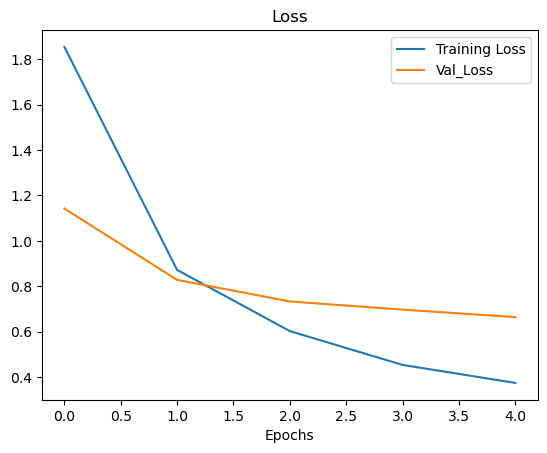

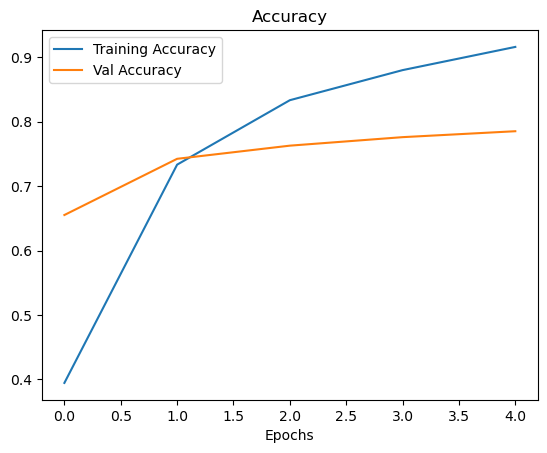

In [16]:
plot_loss(resnet_history)

### Creating and Testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [17]:
effnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [18]:
effnet_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.legacy.Adam(),
                    metrics=['accuracy'])

effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [19]:
effnet_history = effnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data, validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback('10_food_classes_10_percent', 'effnet_model')])

Saving TensorBoard log files to: 10_food_classes_10_percent/effnet_model/20240314-133315
Epoch 1/5
24/24 [==============================] - 29s 1s/step - loss: 1.8488 - accuracy: 0.4480 - val_loss: 1.2972 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 27s 1s/step - loss: 1.0626 - accuracy: 0.7827 - val_loss: 0.8646 - val_accuracy: 0.8284
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.7586 - accuracy: 0.8373 - val_loss: 0.6950 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.6112 - accuracy: 0.8667 - val_loss: 0.6101 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.5177 - accuracy: 0.8787 - val_loss: 0.5570 - val_accuracy: 0.8608


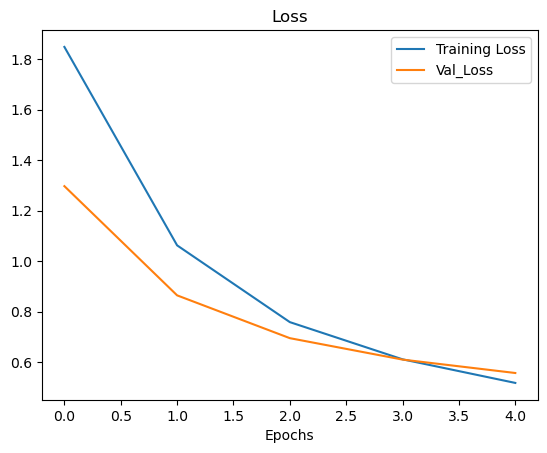

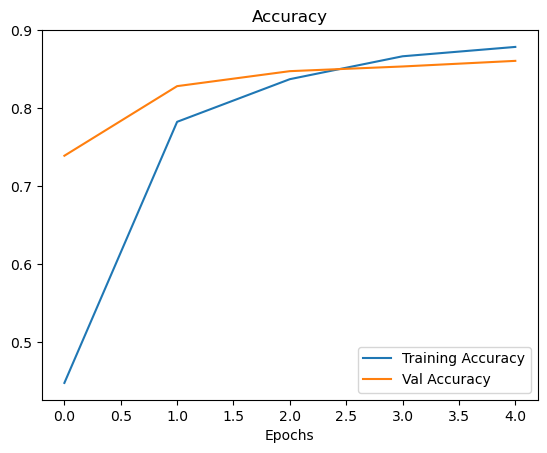

In [20]:
plot_loss(effnet_history)

In [ ]:
#Upload TensorBoard Dev Records
